<a href="https://colab.research.google.com/github/DemonFlexCouncil/DDSP-48kHz-Stereo/blob/master/ddsp/colab/ddsp_train_and_timbre_transfer_48kHz_stereo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##### Copyright 2020 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");





In [ ]:
# Copyright 2020 Google LLC. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Train & Timbre Transfer--DDSP Autoencoder on GPU--48kHz/Stereo

Made by [Google Magenta](https://magenta.tensorflow.org/)--altered by [Flex Council](https://soundcloud.com/flexcouncil)

**A Little Background**

A producer friend of mine turned me on to Magenta’s DDSP, and I’m glad he did. In my mind it represents the way forward for AI music. Finally we have a glimpse inside the black box, with access to musical parameters as well as neural net hyperparameters. And DDSP leverages decades of studio knowledge by utilizing traditional processors like synthesizers and effects. One can envision a time when DDSP-like elements will sit at the heart of production DAWs.

DDSP will accept most audio sample rates and formats. However, native 48 kHz/stereo datasets and primers will sound best. Output files are always 48 kHz/stereo. You can upload datasets and primers via Google Drive.

According to Magenta’s paper, this algorithm was intended as proof of concept, but I wanted to bend it more towards a tool for producers. I bumped the sample rate up to 48 kHz and made it stereo. I also introduced a variable render length so you can feed it loops or phrases. However, there are limits to this parameter. The total number of samples in your render length (number of seconds * 48000) must be evenly divisible by 800. In practice, this means using round-numbered or highly-divisible tempos (105, 96, 90, 72, 50…) or using material that does not depend on tempo.

Also note that longer render times may require a smaller batch size, which is currently set at 8 for a 4-second render. This may diminish audio quality, so use shorter render times if at all possible.

You can train with or without latent vectors, z(t). There is a tradeoff here. The lack of latent vectors allows for more pronounced shifts in the “Modify Conditioning” section, but the rendered audio sounds cloudier. The default mode is latent vectors.

The dataset and primer files must be WAVE format, stereo, and 48 kHz. Most DAWs and audio editors have a 48 kHz export option, including the free [Audacity](https://www.audacityteam.org/). There appears to be a lower limit on the total size of the dataset, somewhere around 5MB. Smaller sizes may produce blank TFRecords (0 bytes.) Also, Colaboratory may throw memory errors if it encounters a large single audio file for the dataset—cut the file into smaller pieces if this happens.

<img src="https://storage.googleapis.com/ddsp/additive_diagram/ddsp_autoencoder.png" alt="DDSP Autoencoder figure" width="700">


**Note that bash commands are prefixed with a `!` inside of Colaboratory, but you would leave them out if running directly in a terminal.**

## **Step 1**--Install dependencies
First we install the required dependencies with `pip` (takes about 5 minutes.)

In [2]:
!pip install mir_eval
!pip install apache_beam
!pip install crepe
!pip install pydub
!pip3 install ffmpeg-normalize
import os
import re
import glob
import tensorflow as tf
import tensorflow_probability as tfp

## **Step 2**--Login and mount your Google Drive

This will require authentication of your Google account. After authentication, you should be able to see your Drive in the file browser on the left panel--click the folder icon to make it visible.

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## **Step 3**--Set render length

Determines the length of audio slices for training and resynthesis. Decimals are OK.

In [4]:
RENDER_SECONDS =  4.0#@param {type:"number", min:1, max:10}
RENDER_SAMPLES = int(RENDER_SECONDS * 48000)

if ((RENDER_SAMPLES % 800) != 0):
  raise ValueError("Number of samples at 48kHz must be divisble by 800.")

## **Step 4**--Latent vectors mode

Uncheck the box to train without z(t).

In [5]:
LATENT_VECTORS = False #@param{type:"boolean"}

## **Step 5**--Set your training directory on Drive and get the DDSP repository from Github

In the left panel, pick a folder on your Drive where you want to upload audio files and store checkpoints. Then right-click on the folder and select "Copy path." Enter the path below.

In [6]:
DRIVE_DIR = "/content/drive/MyDrive/ddsp_test28"#@param {type:"string"}

if LATENT_VECTORS:
  !git clone https://github.com/FlexCouncil/DDSP-48kHz-Stereo.git
else:
  !git clone https://github.com/FlexCouncil/DDSP-48kHz-Stereo-NoLatents.git

AUDIO_DIR = '/content/data/audio'
!mkdir -p $AUDIO_DIR
AUDIO_FILEPATTERN = AUDIO_DIR + '/*'
AUDIO_INPUT_DIR = DRIVE_DIR + '/audio_input'
AUDIO_OUTPUT_DIR = DRIVE_DIR + '/audio_output'
CKPT_OUTPUT_DIR = DRIVE_DIR + '/ckpt'
SAVE_DIR = os.path.join(DRIVE_DIR, 'model')

%cd $DRIVE_DIR
!mkdir -p audio_input audio_output ckpt data model primer

Cloning into 'DDSP-48kHz-Stereo-NoLatents'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 88 (delta 26), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (88/88), 7.05 MiB | 5.22 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/drive/MyDrive/ddsp_test28


## **Step 6**--Upload your audio files to Drive and create a TFRecord dataset
 In your Drive interface, put your training audio files in the "audio_input" directory, which is inside the directory you set as DRIVE_DIR. The algorithm typically works well with audio from a single acoustic environment.

Preprocessing involves inferring the fundamental frequency (the main pitch) with [CREPE](http://github.com/marl/crepe), and computing the loudness. These features will then be stored in sharded [TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord) files for easier loading. Depending on the amount of input audio, this process usually takes a few minutes with a GPU.

In [9]:
audio_files = glob.glob(os.path.join(AUDIO_INPUT_DIR, '*.wav'))

for fname in audio_files:
  target_name = os.path.join(AUDIO_DIR,
                             os.path.basename(fname).replace(' ', '_'))
  print('Copying {} to {}'.format(fname, target_name))
  !cp "$fname" $target_name

TRAIN_TFRECORD = '/content/data/train.tfrecord'
TRAIN_TFRECORD_FILEPATTERN = TRAIN_TFRECORD + '*'

drive_data_dir = os.path.join(DRIVE_DIR, 'data')
drive_dataset_files = glob.glob(drive_data_dir + '/*')

# Make a new dataset.
if not glob.glob(AUDIO_FILEPATTERN):
  raise ValueError('No audio files found. Please use the previous cell to '
                    'upload.')

if LATENT_VECTORS:
  !python /content/DDSP-48kHz-Stereo/ddsp/training/data_preparation/prepare_tfrecord.py \
    --input_audio_filepatterns=$AUDIO_FILEPATTERN \
    --output_tfrecord_path=$TRAIN_TFRECORD \
    --num_shards=10 \
    --example_secs=$RENDER_SECONDS \
    --alsologtostderr
else:
  !python /content/DDSP-48kHz-Stereo-NoLatents/ddsp/training/data_preparation/prepare_tfrecord.py \
    --input_audio_filepatterns=$AUDIO_FILEPATTERN \
    --output_tfrecord_path=$TRAIN_TFRECORD \
    --num_shards=10 \
    --example_secs=$RENDER_SECONDS \
    --alsologtostderr

TRAIN_TFRECORD_DIR = DRIVE_DIR + '/data'
TRAIN_TFRECORD_DIR = TRAIN_TFRECORD_DIR.replace("My Drive", "My\ Drive")
!cp $TRAIN_TFRECORD_FILEPATTERN $TRAIN_TFRECORD_DIR

Copying /content/drive/MyDrive/ddsp_test28/audio_input/Sisters-Of-Mercy--This-Corrosion.wav to /content/data/audio/Sisters-Of-Mercy--This-Corrosion.wav
2024-07-24 18:40:11.555988: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 18:40:11.556099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 18:40:11.559919: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 18:40:13.018872: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0724 18:40:15.261372 136106322350080 statecache.py:234] Creating state cache with size 1

## **Step 7**--Save dataset statistics for timbre transfer

We now compute quantile normalization, which helps to match the loudness of the timbre transfer inputs to the loudness of the dataset. This information is saved in a pickle file.

In [10]:
if LATENT_VECTORS:
  %cd /content/DDSP-48kHz-Stereo/ddsp/
else:
  %cd /content/DDSP-48kHz-Stereo-NoLatents/ddsp/

from colab import colab_utils
from training import data

TRAIN_TFRECORD = '/content/data/train.tfrecord'
TRAIN_TFRECORD_FILEPATTERN = TRAIN_TFRECORD + '*'

data_provider = data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN, example_secs=RENDER_SECONDS)
dataset = data_provider.get_dataset(shuffle=False)

PICKLE_FILE_PATH = os.path.join(SAVE_DIR, 'dataset_statistics.pkl')

colab_utils.save_dataset_statistics(data_provider, PICKLE_FILE_PATH, batch_size=1)

/content/DDSP-48kHz-Stereo-NoLatents/ddsp
Calculating dataset statistics for <training.data.TFRecordProvider object at 0x77feabb2b010>
Done! Saved to: /content/drive/MyDrive/ddsp_test28/model/dataset_statistics.pkl


## **Step 8**--Train model

DDSP was designed to model a single instrument, but you can also get interesting results by training it on sparse multi-timbral material.

Note that  [gin configuration files](https://github.com/google/gin-config) specify parameters for the both the model architecture (solo_instrument.gin) and the dataset (tfrecord.gin.) These parameters can be overriden in the run script below (!python ddsp/ddsp_run.py).

### Training Notes:
* Models typically perform well when the loss drops to the range of ~7.0-8.5.
* Depending on the dataset, this can take anywhere from 30k-90k training steps.
* The default number of training steps is 90k, but you can stop training at any time (select "Interrupt execution" from the "Runtime" menu.) You can also adjust this parameter in the code below (train_util.train.num_steps.)
* With a relatively fast GPU, training takes about 3-9 hours. Free GPUs may be slower.
* By default, checkpoints will be saved every 300 steps with a maximum of 10 checkpoints. These parameters can be adjusted below with "train_util.train.steps_per_save" and "trainers.Tra_stepsiner.checkpoints_to_keep," respectively.
* If your Colaboratory runtime has stopped, re-run steps 1 through 8 to resume training from your most recent checkpoint.

In [11]:
if LATENT_VECTORS:
  %cd /content/DDSP-48kHz-Stereo
else:
  %cd /content/DDSP-48kHz-Stereo-NoLatents

TRAIN_TFRECORD = '/content/data/train.tfrecord'
TRAIN_TFRECORD_FILEPATTERN = TRAIN_TFRECORD + '*'

!python ddsp/ddsp_run.py \
  --mode=train \
  --alsologtostderr \
  --save_dir="$SAVE_DIR" \
  --gin_file=models/solo_instrument.gin \
  --gin_file=datasets/tfrecord.gin \
  --gin_param="TFRecordProvider.file_pattern='/content/data/train.tfrecord*'" \
  --gin_param="TFRecordProvider.example_secs=$RENDER_SECONDS" \
  --gin_param="Autoencoder.n_samples=$RENDER_SAMPLES" \
  --gin_param="batch_size=2" \
  --gin_param="train_util.train.num_steps=90000" \
  --gin_param="train_util.train.steps_per_save=1" \
  --gin_param="trainers.Tra_stepsiner.checkpoints_to_keep=10"

/content/DDSP-48kHz-Stereo-NoLatents
2024-07-24 19:06:54.654354: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 19:06:54.654428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 19:06:54.656389: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 19:06:56.086485: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/content/DDSP-48kHz-Stereo-NoLatents/ddsp/ddsp_run.py:75: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
I072

## **Step 9**--Timbre transfer imports

Now we start the inference process with importing the necessary timbre transfer packages.

In [12]:
if LATENT_VECTORS:
  %cd /content/DDSP-48kHz-Stereo/ddsp
else:
  %cd /content/DDSP-48kHz-Stereo-NoLatents/ddsp

# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")

import copy
import time
import pydub
import gin
import crepe
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import tensorflow_datasets as tfds

import core
import spectral_ops
from training import metrics
from training import models
from colab import colab_utils
from colab.colab_utils import (auto_tune, detect_notes, fit_quantile_transform, get_tuning_factor, download, play, record, specplot, upload, DEFAULT_SAMPLE_RATE)
from google.colab import files

# Helper Functions
sample_rate = 48000

print('Done!')

/content/DDSP-48kHz-Stereo-NoLatents/ddsp
Done!


## **Step 10**--Process audio primer

The "primer" file will graft its frequency and loudness information onto the rendered audio file, similar to a vocoder. You can then use the sliders in the "Modify Conditioning" section to further alter the rendered file.

Put your audio primer file in the "primer" directory, which is inside the directory you set as DRIVE_DIR. Enter the file name of the primer on the line below.

In [13]:
PRIMER_DIR = DRIVE_DIR + '/primer/'
PRIMER_FILE =  "OTO16S48a.wav"#@param {type:"string"}

# Check for .wav extension
match = re.search(r'.wav', PRIMER_FILE)
if match:
  print ('')
else:
  PRIMER_FILE = PRIMER_FILE + ".wav"

PATH_TO_PRIMER = PRIMER_DIR + PRIMER_FILE

from scipy.io.wavfile import read as read_audio
from scipy.io.wavfile import write as write_audio

primer_sample_rate, audio = read_audio(PATH_TO_PRIMER)

# Setup the session.
spectral_ops.reset_crepe()

# Compute features.
start_time = time.time()
audio_features = metrics.compute_audio_features(audio)
audio_features['loudness_dbM'] = audio_features['loudness_dbM'].astype(np.float32)
audio_features['loudness_dbL'] = audio_features['loudness_dbL'].astype(np.float32)
audio_features['loudness_dbR'] = audio_features['loudness_dbR'].astype(np.float32)
audio_features_mod = None
print('Audio features took %.1f seconds' % (time.time() - start_time))


Audio features took 759.9 seconds


## **Step 11**--Load the most recent checkpoint

In [14]:
import collections
import collections.abc

# Patch collections module
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableMapping = collections.abc.MutableMapping
collections.MutableSet = collections.abc.MutableSet
collections.Set = collections.abc.Set

# Copy most recent checkpoint to "ckpt" folder
%cd $DRIVE_DIR/ckpt/
!rm *
CHECKPOINT_ZIP = 'ckpt.zip'
latest_checkpoint_fname = os.path.basename(tf.train.latest_checkpoint(SAVE_DIR))  + '*'
!cd "$SAVE_DIR"
!cd "$SAVE_DIR" && zip $CHECKPOINT_ZIP $latest_checkpoint_fname* operative_config-0.gin dataset_statistics.pkl
!cp "$SAVE_DIR/$CHECKPOINT_ZIP" "$DRIVE_DIR/ckpt/"
!unzip -o "$CHECKPOINT_ZIP"
!rm "$CHECKPOINT_ZIP"
%cd $SAVE_DIR
!rm "$CHECKPOINT_ZIP"
model_dir = DRIVE_DIR + '/ckpt/'
gin_file = os.path.join(model_dir, 'operative_config-0.gin')

# Load the dataset statistics.
DATASET_STATS = None
dataset_stats_file = os.path.join(model_dir, 'dataset_statistics.pkl')
print(f'Loading dataset statistics from {dataset_stats_file}')
try:
  if tf.io.gfile.exists(dataset_stats_file):
    with tf.io.gfile.GFile(dataset_stats_file, 'rb') as f:
      DATASET_STATS = pickle.load(f)
except Exception as err:
  print('Loading dataset statistics from pickle failed: {}.'.format(err))

# Parse gin config,
with gin.unlock_config():
  gin.parse_config_file(gin_file, skip_unknown=True)

# Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
ckpt_files = [f for f in tf.io.gfile.listdir(model_dir) if 'ckpt' in f]
ckpt_name = ckpt_files[0].split('.')[0]
ckpt = os.path.join(model_dir, ckpt_name)

# Ensure dimensions and sampling rates are equal
time_steps_train = gin.query_parameter('DefaultPreprocessor.time_steps')
n_samples_train = RENDER_SAMPLES
hop_size = int(n_samples_train / time_steps_train)
time_steps = int(audio_features['audioL'].shape[1] / hop_size)
n_samples = time_steps * hop_size

# Trim all input vectors to correct lengths
for key in ['f0_hzM', 'f0_hzL', 'f0_hzR', 'f0_confidenceM', 'f0_confidenceL', 'f0_confidenceR']:
  audio_features[key] = audio_features[key][:time_steps]

for key in ['loudness_dbM', 'loudness_dbL', 'loudness_dbR']:
  audio_features[key] = audio_features[key][:, :time_steps]

audio_features['audioM'] = audio_features['audioM'][:, :n_samples]
audio_features['audioL'] = audio_features['audioL'][:, :n_samples]
audio_features['audioR'] = audio_features['audioR'][:, :n_samples]

# Set up the model just to predict audio given new conditioning
model = models.Autoencoder()
model.restore(ckpt)

# Build model by running a batch through it.
start_time = time.time()
_ = model(audio_features, training=False)
print('Restoring model took %.1f seconds' % (time.time() - start_time))

/content/drive/MyDrive/ddsp_test28/ckpt
rm: cannot remove '*': No such file or directory
  adding: ckpt-2.data-00000-of-00001 (deflated 6%)
  adding: ckpt-2.index (deflated 79%)
  adding: operative_config-0.gin (deflated 75%)
  adding: dataset_statistics.pkl (deflated 60%)
Archive:  ckpt.zip
  inflating: ckpt-2.data-00000-of-00001  
  inflating: ckpt-2.index            
  inflating: operative_config-0.gin  
  inflating: dataset_statistics.pkl  
/content/drive/MyDrive/ddsp_test28/model
Loading dataset statistics from /content/drive/MyDrive/ddsp_test28/ckpt/dataset_statistics.pkl
Restoring model took 39.1 seconds


## **Step 12** (optional)--Modify Conditioning

Here you can adjust the parameters affecting the final render.

Autotuning... 
Inferred key: D  
Tuning offset: 34 cents
Autotuning... 
Inferred key: A  
Tuning offset: 30 cents


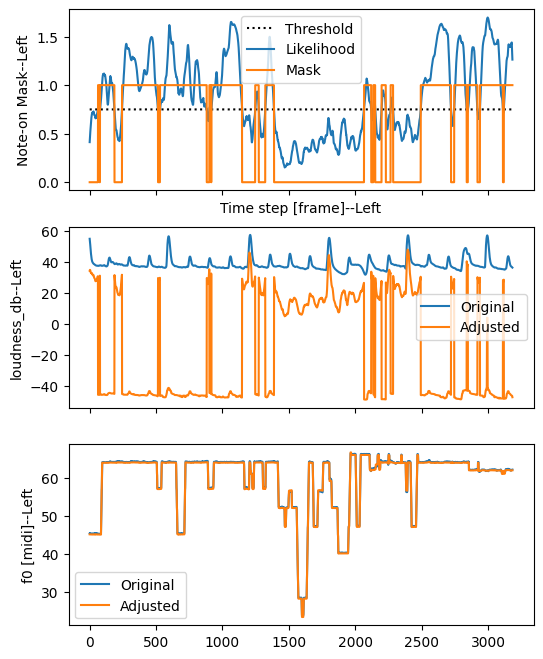

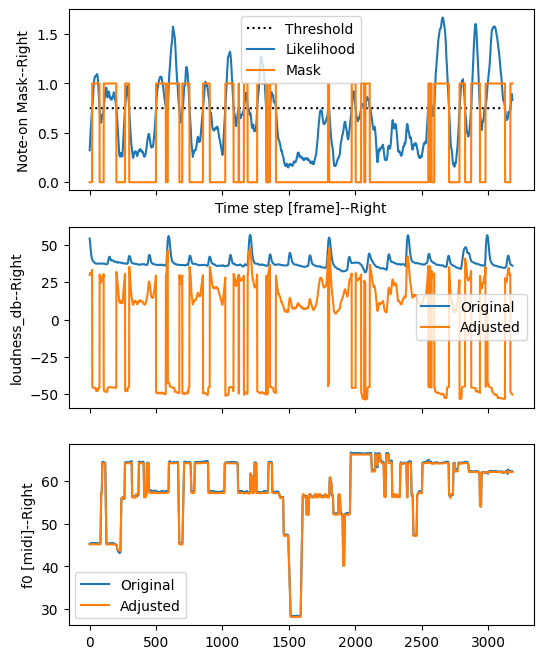

In [15]:
#@markdown ## Note Detection

#@markdown You can leave this at 1.0 for most cases
threshold = 0.75 #@param {type:"slider", min: 0.0, max:2.0, step:0.01}


#@markdown ## Automatic

ADJUST = True #@param{type:"boolean"}

#@markdown Quiet parts without notes detected (dB)
quiet = 42 #@param {type:"slider", min: 0, max:60, step:1}

#@markdown Force pitch to nearest note (amount)
autotune = 0.6 #@param {type:"slider", min: 0.0, max:1.0, step:0.1}

#@markdown ## Manual


#@markdown Shift the pitch (octaves)
pitch_shift =  -1 #@param {type:"slider", min:-2, max:2, step:1}

#@markdown Adjsut the overall loudness (dB)
loudness_shift = 4 #@param {type:"slider", min:-20, max:20, step:1}


audio_features_mod = {k: v.copy() for k, v in audio_features.items()}

## Helper functions.
def shift_ld(audio_features, ld_shiftL=0.0, ld_shiftR=0.0):
  """Shift loudness by a number of ocatves."""
  audio_features['loudness_dbL'] += ld_shiftL
  audio_features['loudness_dbR'] += ld_shiftR
  return audio_features


def shift_f0(audio_features, pitch_shiftL=0.0, pitch_shiftR=0.0):
  """Shift f0 by a number of ocatves."""
  audio_features['f0_hzL'] *= 2.0 ** (pitch_shiftL)
  audio_features['f0_hzL'] = np.clip(audio_features['f0_hzL'],
                                    0.0,
                                    librosa.midi_to_hz(110.0))
  audio_features['f0_hzR'] *= 2.0 ** (pitch_shiftR)
  audio_features['f0_hzR'] = np.clip(audio_features['f0_hzR'],
                                    0.0,
                                    librosa.midi_to_hz(110.0))
  return audio_features


mask_on = None

if ADJUST and DATASET_STATS is not None:
  # Detect sections that are "on".
  mask_onL, note_on_valueL = detect_notes(audio_features['loudness_dbL'],
                                        audio_features['f0_confidenceL'],
                                        threshold)

  mask_onR, note_on_valueR = detect_notes(audio_features['loudness_dbR'],
                                        audio_features['f0_confidenceR'],
                                        threshold)

  if np.any(mask_onL):
    # Shift the pitch register.
    target_mean_pitchL = DATASET_STATS['mean_pitchL']
    target_mean_pitchR = DATASET_STATS['mean_pitchR']
    pitchL = core.hz_to_midi(audio_features['f0_hzL'])
    pitchR = core.hz_to_midi(audio_features['f0_hzR'])
    pitchL = np.expand_dims(pitchL, axis=0)
    pitchR = np.expand_dims(pitchR, axis=0)
    mean_pitchL = np.mean(pitchL[mask_onL])
    mean_pitchR = np.mean(pitchR[mask_onR])
    p_diffL = target_mean_pitchL - mean_pitchL
    p_diffR = target_mean_pitchR - mean_pitchR
    p_diff_octaveL = p_diffL / 12.0
    p_diff_octaveR = p_diffR / 12.0
    round_fnL = np.floor if p_diff_octaveL > 1.5 else np.ceil
    round_fnR = np.floor if p_diff_octaveR > 1.5 else np.ceil
    p_diff_octaveL = round_fnL(p_diff_octaveL)
    p_diff_octaveR = round_fnR(p_diff_octaveR)

    audio_features_mod = shift_f0(audio_features_mod, p_diff_octaveL, p_diff_octaveR)

    # Quantile shift the note_on parts.
    _, loudness_normL = colab_utils.fit_quantile_transform(
        audio_features['loudness_dbL'],
        mask_onL,
        inv_quantile=DATASET_STATS['quantile_transformL'])

    # Quantile shift the note_on parts.
    _, loudness_normR = colab_utils.fit_quantile_transform(
        audio_features['loudness_dbR'],
        mask_onR,
        inv_quantile=DATASET_STATS['quantile_transformR'])

    # Turn down the note_off parts.
    mask_offL = np.logical_not(mask_onL)
    mask_offR = np.logical_not(mask_onR)
    loudness_normL = np.squeeze(loudness_normL)
    loudness_normR = np.squeeze(loudness_normR)
    loudness_normL[np.squeeze(mask_offL)] -=  quiet * (1.0 - note_on_valueL[mask_offL])
    loudness_normR[np.squeeze(mask_offR)] -=  quiet * (1.0 - note_on_valueR[mask_offR])
    loudness_normL = np.reshape(loudness_normL, audio_features['loudness_dbL'].shape)
    loudness_normR = np.reshape(loudness_normR, audio_features['loudness_dbR'].shape)

    audio_features_mod['loudness_dbL'] = loudness_normL
    audio_features_mod['loudness_dbR'] = loudness_normR

    # Auto-tune.
    if autotune:
      f0_midiL = np.array(core.hz_to_midi(audio_features_mod['f0_hzL']))
      f0_midiR = np.array(core.hz_to_midi(audio_features_mod['f0_hzR']))
      tuning_factorL = get_tuning_factor(f0_midiL, audio_features_mod['f0_confidenceL'], np.squeeze(mask_onL))
      tuning_factorR = get_tuning_factor(f0_midiR, audio_features_mod['f0_confidenceR'], np.squeeze(mask_onR))
      f0_midi_atL = auto_tune(f0_midiL, tuning_factorL, np.squeeze(mask_onL), amount=autotune)
      f0_midi_atR = auto_tune(f0_midiR, tuning_factorR, np.squeeze(mask_onR), amount=autotune)
      audio_features_mod['f0_hzL'] = core.midi_to_hz(f0_midi_atL)
      audio_features_mod['f0_hzR'] = core.midi_to_hz(f0_midi_atR)

  else:
    print('\nSkipping auto-adjust (no notes detected or ADJUST box empty).')

else:
  print('\nSkipping auto-adujst (box not checked or no dataset statistics found).')

# Manual Shifts.
audio_features_mod = shift_ld(audio_features_mod, loudness_shift, loudness_shift)
audio_features_mod = shift_f0(audio_features_mod, pitch_shift, pitch_shift)

TRIM = -15

# Plot Features.
has_maskL = int(mask_onL is not None)
n_plots = 3 if has_maskL else 2
figL, axesL = plt.subplots(nrows=n_plots,
                      ncols=1,
                      sharex=True,
                      figsize=(2*n_plots, 8))

if has_maskL:
  ax = axesL[0]
  ax.plot(np.ones_like(np.squeeze(mask_onL)[:TRIM]) * threshold, 'k:')
  ax.plot(np.squeeze(note_on_valueL)[:TRIM])
  ax.plot(np.squeeze(mask_onL)[:TRIM])
  ax.set_ylabel('Note-on Mask--Left')
  ax.set_xlabel('Time step [frame]--Left')
  ax.legend(['Threshold', 'Likelihood','Mask'])

ax = axesL[0 + has_maskL]
ax.plot(np.squeeze(audio_features['loudness_dbL'])[:TRIM])
ax.plot(np.squeeze(audio_features_mod['loudness_dbL'])[:TRIM])
ax.set_ylabel('loudness_db--Left')
ax.legend(['Original','Adjusted'])

ax = axesL[1 + has_maskL]
ax.plot(librosa.hz_to_midi(np.squeeze(audio_features['f0_hzL'])[:TRIM]))
ax.plot(librosa.hz_to_midi(np.squeeze(audio_features_mod['f0_hzL'])[:TRIM]))
ax.set_ylabel('f0 [midi]--Left')
_ = ax.legend(['Original','Adjusted'])

has_maskR = int(mask_onR is not None)
n_plots = 3 if has_maskR else 2
figR, axesR = plt.subplots(nrows=n_plots,
                      ncols=1,
                      sharex=True,
                      figsize=(2*n_plots, 8))

if has_maskR:
  ax = axesR[0]
  ax.plot(np.ones_like(np.squeeze(mask_onR)[:TRIM]) * threshold, 'k:')
  ax.plot(np.squeeze(note_on_valueR)[:TRIM])
  ax.plot(np.squeeze(mask_onR)[:TRIM])
  ax.set_ylabel('Note-on Mask--Right')
  ax.set_xlabel('Time step [frame]--Right')
  ax.legend(['Threshold', 'Likelihood','Mask'])

ax = axesR[0 + has_maskR]
ax.plot(np.squeeze(audio_features['loudness_dbR'])[:TRIM])
ax.plot(np.squeeze(audio_features_mod['loudness_dbR'])[:TRIM])
ax.set_ylabel('loudness_db--Right')
ax.legend(['Original','Adjusted'])

ax = axesR[1 + has_maskR]
ax.plot(librosa.hz_to_midi(np.squeeze(audio_features['f0_hzR'])[:TRIM]))
ax.plot(librosa.hz_to_midi(np.squeeze(audio_features_mod['f0_hzR'])[:TRIM]))
ax.set_ylabel('f0 [midi]--Right')
_ = ax.legend(['Original','Adjusted'])

## **Step 13**--Render audio

After running this cell, your final rendered file should be downloaded automatically. If it doesn't, look for it in the "audio_output/normalized" directory, which is inside the directory you set as DRIVE_DIR. You can also download unnormalized stereo and mono renders from the "audio_output" directory.

In [16]:
%cd $AUDIO_OUTPUT_DIR
!mkdir -p normalized
!rm normalized/*

af = audio_features if audio_features_mod is None else audio_features_mod

# Run a batch of predictions.
start_time = time.time()
audio_genM, audio_genL, audio_genR = model(af, training=False)
print('Prediction took %.1f seconds' % (time.time() - start_time))

audio_genL = np.expand_dims(np.squeeze(audio_genL.numpy()), axis=1)
audio_genR = np.expand_dims(np.squeeze(audio_genR.numpy()), axis=1)
audio_genS = np.concatenate((audio_genL, audio_genR), axis=1)
audio_genM = np.expand_dims(np.squeeze(audio_genM.numpy()), axis=1)

write_audio("renderS.wav", 48000, audio_genS)
write_audio("renderM.wav", 48000, audio_genM)

!ffmpeg-normalize renderS.wav -o normalized/render.wav -t -15 -ar 48000

colab_utils.download("normalized/render.wav")

/content/drive/MyDrive/ddsp_test28/audio_output
rm: cannot remove 'normalized/*': No such file or directory
Prediction took 30.8 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Step 14** (optional)--Download your model for later use

In [20]:
from google.colab import files

%cd $CKPT_OUTPUT_DIR
!zip -r checkpoint.zip *
files.download('checkpoint.zip')

/content/drive/MyDrive/ddsp_test28/ckpt
  adding: ckpt-2.data-00000-of-00001 (deflated 6%)
  adding: ckpt-2.index (deflated 79%)
  adding: dataset_statistics.pkl (deflated 60%)
  adding: operative_config-0.gin (deflated 75%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>